In [1]:
from parse_circuit import parse_circuit

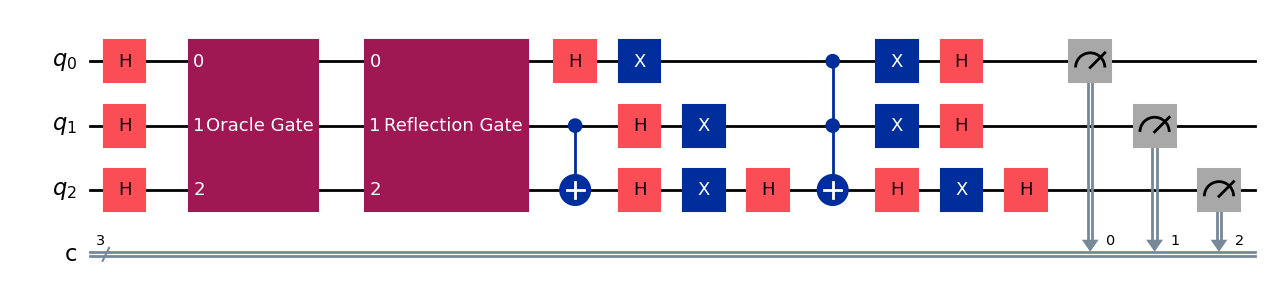

In [2]:
# Example generated circuit code
generated_code = ("qc = QuantumCircuit(3, 3)\n" "qc.h(0)\nqc.h(1)\nqc.h(2)\n" "qc.append(oracle_gate, [0,1,2])\n""qc.append(reflection_gate, [0,1,2])\n" "qc.cx(1, 2)\n" "qc.h(0)\nqc.h(1)\nqc.h(2)\n" "qc.x(0)\nqc.x(1)\nqc.x(2)\n" "qc.h(2)\nqc.mcx([0, 1], 2)\nqc.h(2)\n" "qc.x(0)\nqc.x(1)\nqc.x(2)\n" "qc.h(0)\nqc.h(1)\nqc.h(2)\n" "qc.measure(0, 0)\nqc.measure(1, 1)\nqc.measure(2, 2)\n"
)

# Parse the circuit
quantum_circuit = parse_circuit(generated_code)

# Display the circuit
display(quantum_circuit.draw('mpl'))